<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/TB-Estimator/blob/main/%20UKF%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [66]:

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

In [67]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/Ademola-Olorunnisola/TB-Estimator/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

tb_simulations = import_local_or_github('model_simulation2', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

$$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) = \mathbf{f_0}(\mathbf{x}) + \mathbf{f_1}(\mathbf{x})\bbox[lightgreen]{\alpha} + \mathbf{f_2}(\mathbf{x})\bbox[lightgreen]{\kappa}
$$

$$
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{V} \\[0.3em]
\bbox[yellow]{I} \\[0.3em]
\bbox[yellow]{R} \\[0.3em]
\bbox[pink]{\beta} \\[0.3em]
\bbox[pink]{\sigma}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[lightblue]{\Lambda} - \bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[lightblue]{\mu}\bbox[yellow]{S} \\[0.3em]
0 - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\mu}\bbox[yellow]{V} \\[0.3em]
\bbox[pink]{\beta}\bbox[yellow]{SI} + \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{I} \\[0.3em]
\bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{R}\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
-\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{S} \\[0.3em]
0 \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\alpha} +
\overset{f_2}{\begin{bmatrix}
\bbox[pink]{\beta}\bbox[yellow]{SI} \\[0.3em]
\bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
-\bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\kappa}
$$

# Dynamics and measurement functions

In [68]:
h = tb_simulations.H('observe_IVRЕТ').h

In [69]:
f = tb_simulations.F().f

In [70]:
h(None, None, return_measurement_names=True)

['I', 'V', 'R', 'E', 'T']

In [71]:
def u_func(x_vec, t):
    """vaccination and Treatment rate"""
    I = x_vec[2]
    alpha = 1 / 365
    tau = 1 / 30
    return np.array([alpha, tau])

In [72]:
def f_ode(x_vec, t):
    """Wrapper for odeint"""
    u_vec = u_func(x_vec, t)
    return f(x_vec, u_vec)

In [73]:
N = 500000
x0_true = np.array([
    360000,     # S:
    40000,      # V
    40000,      # E
    25000,      # I
    30000,      # T
    5000,       # R
    0.010,      # beta
    1 / 365,    # eps
    1 / 180,    # gamma
    0.50,       # sigma
    0.03,       # phi
    0.21 * (1 / 180)    #rho
])

# FILTER INITIAL GUESS
x0_filter = np.array([
    # ── Dynamic states (perturbed by 10-20%) ──
    360000 * 1.10,          # S — 10% over-estimate
    40000  * 0.90,          # V — 10% under-estimate
    40000  * 1.15,          # E — 15% over-estimate
    25000  * 0.85,          # I — 15% under-estimate
    30000  * 1.10,          # T — 10% over-estimate
    5000   * 0.90,          # R — 10% under-estimate
    0.010  * 1.20,          # beta  — 20% over-estimate
    (1/365)* 0.90,          # eps   — 10% under-estimate
    (1/180)* 1.10,          # gamma — 10% over-estimate
    0.50   * 0.85,          # sigma — 15% under-estimate
    0.03   * 1.20,          # phi   — 20% over-estimate
    (0.21*(1/180)) * 0.90,  # rho   — 10% under-estimate
])

# Run simulation

In [74]:
t_sim = np.arange(0, 365, 1.0)
result = odeint(f_ode, x0_true, t_sim)

In [75]:
x_sim = {
    'S':     result[:, 0],
    'V':     result[:, 1],
    'E':     result[:, 2],
    'I':     result[:, 3],
    'T':     result[:, 4],
    'R':     result[:, 5],
    'beta':  result[:, 6],
    'eps':   result[:, 7],
    'gamma': result[:, 8],
    'sigma': result[:, 9],
    'phi':   result[:, 10],
    'rho':   result[:, 11],
}

In [76]:
u_sim = {'alpha': [], 'tau': []}
for i in range(len(t_sim)):
    u = u_func(result[i], t_sim[i])
    u_sim['alpha'].append(u[0])
    u_sim['tau'].append(u[1])

In [77]:
y_sim_absolute = {
    'S_absolute': x_sim['S'],
    'V_absolute': x_sim['V'],
    'E_absolute': x_sim['E'],
    'I_absolute': x_sim['I'],
    'T_absolute': x_sim['T'],
    'R_absolute': x_sim['R'],
    'beta': x_sim['beta'],
    'eps': x_sim['eps'],
    'gamma': x_sim['gamma'],
    'sigma': x_sim['sigma'],
    'phi': x_sim['phi'],
    'rho': x_sim['rho']
}

# Simulate noisy measurements

In [78]:
measurement_noise_stds = {
    'S_absolute': 10000.0,
    'I_absolute': 2500.0,
    'V_absolute': 4000.0,
    'R_absolute': 5000.0,
    'E_absolute': 4000.0,
    'T_absolute': 3000.0,
    'beta':  1000,
    'eps':   3000,
    'gamma': 10000,
    'sigma': 4500,
    'phi':   2200,
    'rho':   10000,
}

In [79]:
# Add noise
np.random.seed(42)
y_noisy_absolute = {
    key: y_sim_absolute[key] + np.random.normal(0, measurement_noise_stds[key], len(t_sim))
    for key in y_sim_absolute.keys()
}

In [80]:
y_noisy = {key: y_noisy_absolute[key]  for key in y_noisy_absolute.keys()}

<Axes: xlabel='Time', ylabel='R_absolute'>

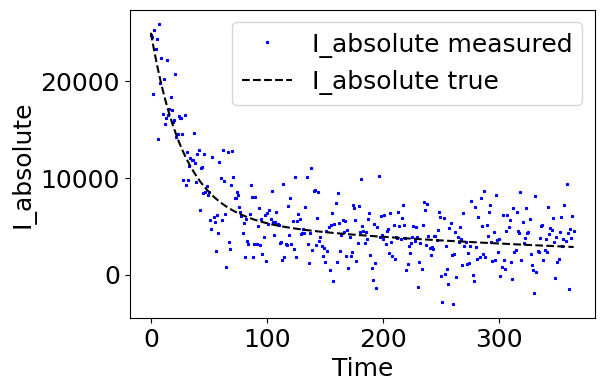

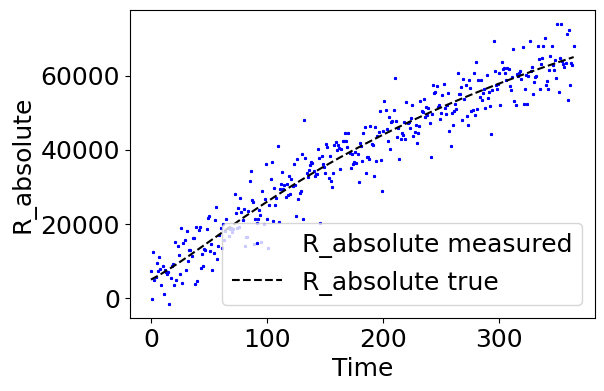

In [81]:

plot_tme(t_sim, x_sim['I'], y_noisy['I_absolute'], label_var='I_absolute')
plot_tme(t_sim, x_sim['R'], y_noisy['R_absolute'], label_var='R_absolute')

### Save data as dataframes

In [82]:
y_noisy_df = pd.DataFrame({
    'I_absolute': y_noisy['I_absolute'],
    'V_absolute': y_noisy['V_absolute'],
    'R_absolute': y_noisy['R_absolute'],
    'E_absolute': y_noisy['E_absolute'],
    'T_absolute': y_noisy['T_absolute']
})
u_sim_df = pd.DataFrame(u_sim)
u0 = np.array([u_sim['alpha'][0], u_sim['tau'][0]])

# Kalman filter parameters and initilization

In [83]:
(0.05 * 360000)**2

324000000.0

In [87]:
P0 = np.diag([
    # ── Dynamic states ──
    (0.05 * 360000)**2,          # S
    (0.05 * 40000)**2,           # V
    (0.05 * 40000)**2,           # E
    (0.05 * 25000)**2,           # I
    (0.05 * 30000)**2,           # T
    (0.05 * 5000)**2,            # R

    # ── Static states / parameters ──
    (0.20 * 0.010)**2,           # beta
    (0.10 * (1/365))**2,         # eps
    (0.10 * (1/180))**2,         # gamma
    (0.15 * 0.50)**2,            # sigma
    (0.20 * 0.03)**2,            # phi
    (0.10 * 0.21*(1/180))**2,    # rho
])

Q = np.diag([
    # ── Dynamic states ──
    (0.01 * 360000)**2,          # S
    (0.01 * 40000)**2,           # V
    (0.01 * 40000)**2,           # E
    (0.01 * 25000)**2,           # I
    (0.01 * 30000)**2,           # T
    (0.01 * 5000)**2,            # R

    # ── Static states / parameters (very small — they don't change) ──
    (1e-6)**2,                   # beta
    (1e-8)**2,                   # eps
    (1e-8)**2,                   # gamma
    (1e-6)**2,                   # sigma
    (1e-6)**2,                   # phi
    (1e-8)**2,                   # rho
])

R_stds = np.array([
    measurement_noise_stds['I_absolute'],
    measurement_noise_stds['V_absolute'],
    measurement_noise_stds['R_absolute'],
    measurement_noise_stds['E_absolute'],
    measurement_noise_stds['T_absolute']
])
R = np.diag(R_stds**2)

# Extended Kalman Filter

In [88]:
EKF = extended_kalman_filter.EKF(
    f, h, x0_filter, u0, P0, Q, R,
    dynamics_type='continuous',
    discretization_timestep=1.0,
    circular_measurements=(0, 0, 0, 0, 0)
)

In [89]:
EKF.estimate(y_noisy_df, u_sim_df)

In [90]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [91]:
# State estimate
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=f(None,None,return_state_names=True))

In [92]:
# Covariance diagonals
P_diags = np.vstack([np.diag(EKF.history['P'][i]) for i in range(len(EKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

## Plots

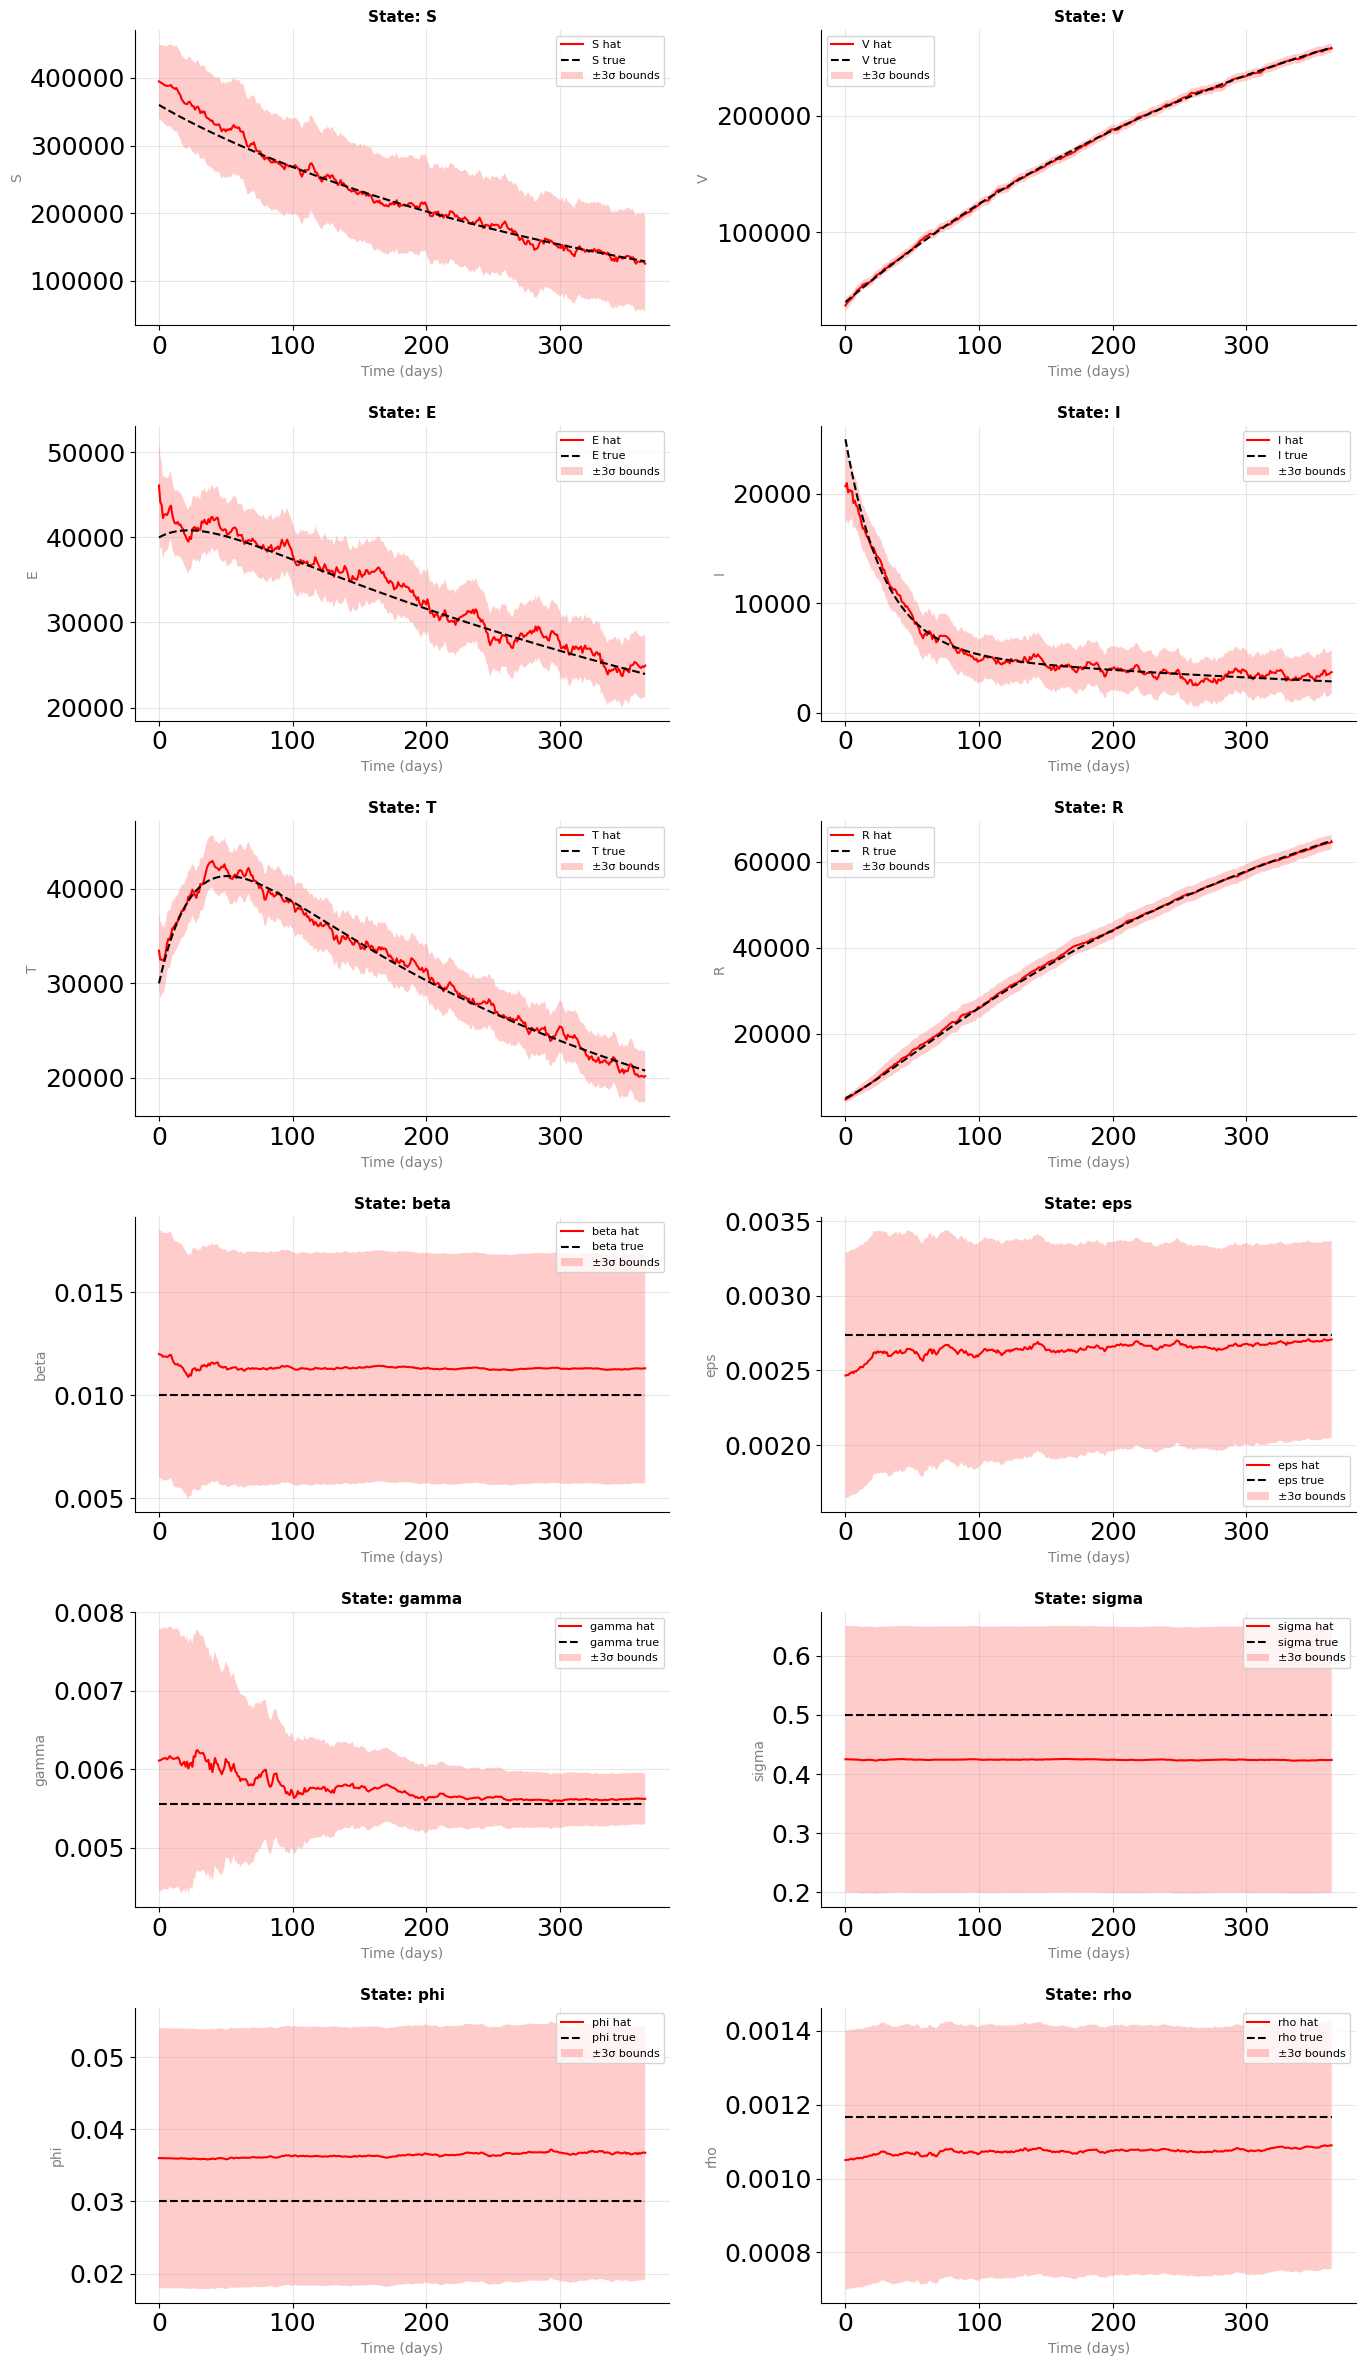

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Get state names
state_names = f(None, None, return_state_names=True)
n_states = len(state_names)  # 12

# 6 rows x 2 columns for 12 states
fig, axes = plt.subplots(6, 2, figsize=(14, 24), dpi=100)
axes = axes.flatten()

# Convert to numpy arrays
x_est_array  = np.array(x_est)
P_diags_array = np.array(P_diags)

# Plot each state
for i, state in enumerate(state_names):
    ax = axes[i]

    x_est_col  = x_est_array[:, i]
    P_diag_col = P_diags_array[:, i]

    plot_tme(t_sim, x_sim[state], None, x_est_col,
             label_var=state, ax=ax)

    # 3-sigma uncertainty bounds
    plus_3sigma  = x_est_col + 3*np.sqrt(np.abs(P_diag_col))
    minus_3sigma = x_est_col - 3*np.sqrt(np.abs(P_diag_col))
    ax.fill_between(t_sim, plus_3sigma, minus_3sigma,
                    facecolor='red', edgecolor='none', alpha=0.2,
                    label='±3σ bounds')

    ax.set_xlabel('Time (days)', fontsize=10, color='gray')
    ax.set_ylabel(state, fontsize=10, color='gray')
    ax.set_title(f'State: {state}', fontsize=11, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

# Unscented Kalman Filter

In [95]:
UKF = unscented_kalman_filter.UKF(
    f, h, x0_filter, u0, P0, Q, R,
    dynamics_type='continuous',
    discretization_timestep=1.0,
    alpha=0.1
)

In [96]:
UKF.estimate(y_noisy_df, u_sim_df)

In [97]:
UKF.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [98]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

In [99]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

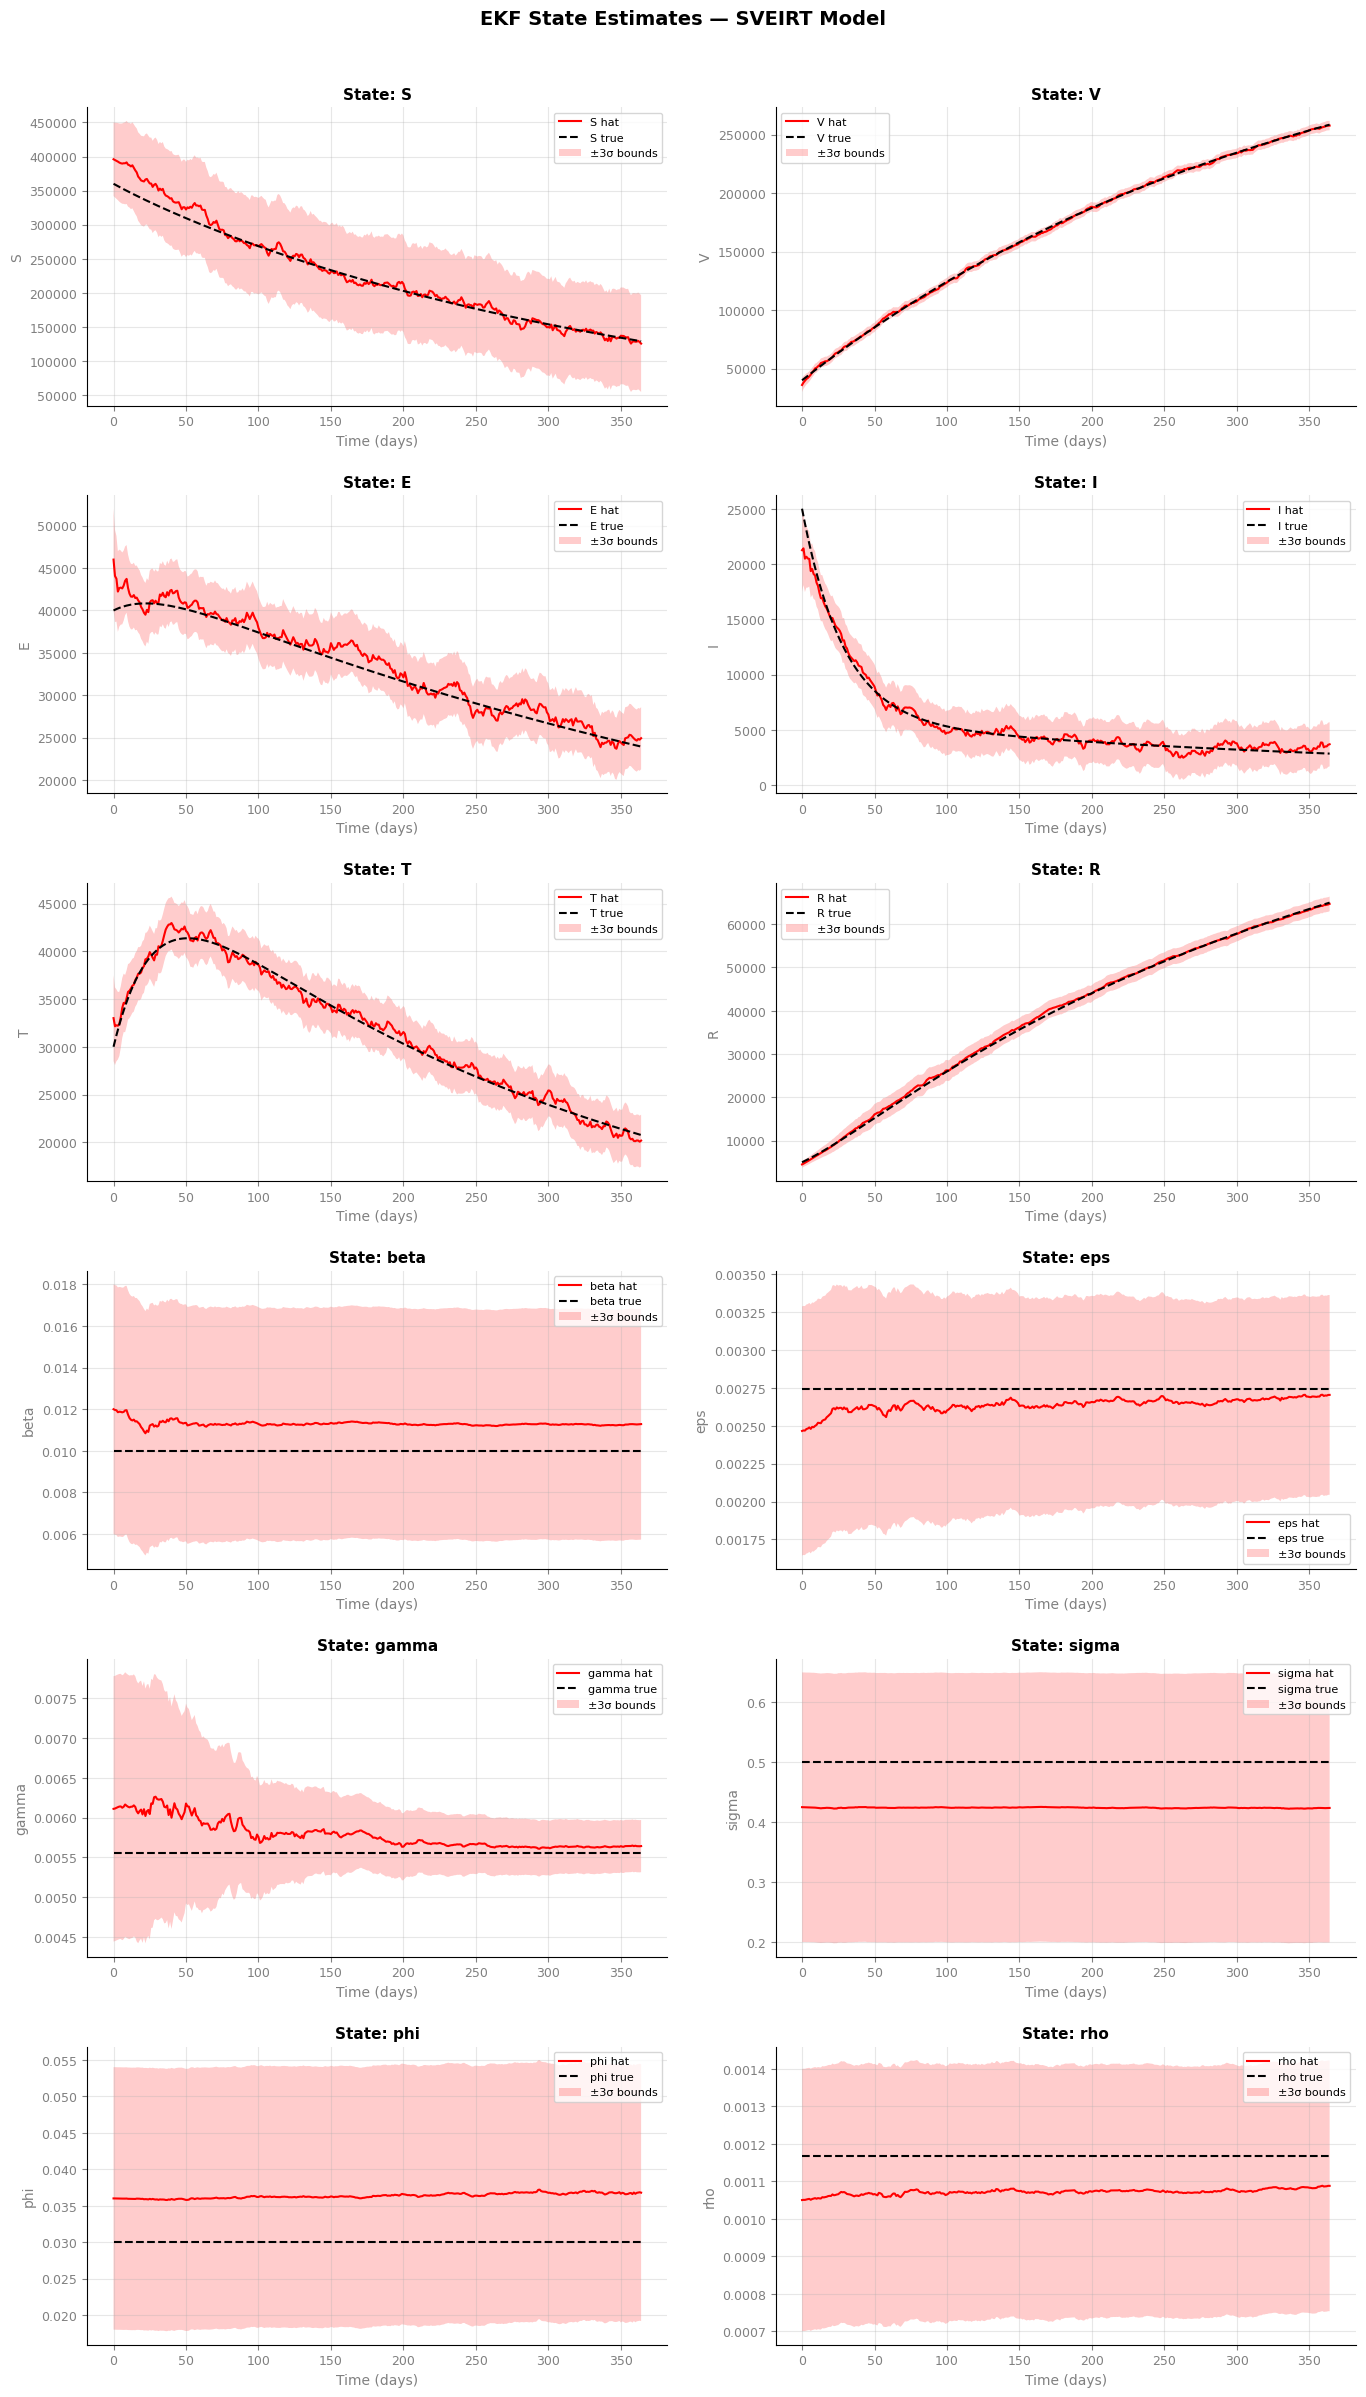

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Get state names
state_names = f(None, None, return_state_names=True)
n_states = len(state_names)  # 12

# 6 rows x 2 columns for all 12 states
fig, axes = plt.subplots(6, 2, figsize=(14, 24), dpi=100)
fig.patch.set_facecolor('white')
axes = axes.flatten()

# Convert to numpy arrays
x_est_array   = np.array(x_est)
P_diags_array = np.array(P_diags)

for i, state in enumerate(state_names):
    ax = axes[i]
    ax.set_facecolor('white')

    x_est_col  = x_est_array[:, i]
    P_diag_col = P_diags_array[:, i]

    plot_tme(t_sim, x_sim[state], None, x_est_col,
             label_var=state, ax=ax)

    # 3-sigma bounds
    plus_3sigma  = x_est_col + 3*np.sqrt(np.abs(P_diag_col))
    minus_3sigma = x_est_col - 3*np.sqrt(np.abs(P_diag_col))

    ax.fill_between(t_sim, plus_3sigma, minus_3sigma,
                    facecolor='red', edgecolor='none',
                    alpha=0.2, label='±3σ bounds')

    ax.set_xlabel('Time (days)', fontsize=10, color='gray')
    ax.set_ylabel(state, fontsize=10, color='gray')
    ax.set_title(f'State: {state}', fontsize=11, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(colors='gray', labelsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('EKF State Estimates — SVEIRT Model',
             fontsize=14, fontweight='bold', y=1.002)
plt.tight_layout()
plt.show()

In [101]:
"""
Nigeria TB Transmission Model — SVEIRT
======================================
Control-affine ODE system with:
  - 6 dynamic compartments: S, V, E, I, T, R
  - 6 static states (estimated): β, σ, γ, ε, φ, ρ
  - 2 control inputs: u1=α (vaccination), u2=τ (treatment initiation)
  - Frequency-dependent (N-weighted) transmission
  - Exogenous reinfection φRI/N
  - Treatment failure loop ρT → I

Estimators: UKF (primary) and EKF (comparison)
Validation:  Synthetic data + real Nigeria WHO annual data
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import solve_ivp
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import warnings
warnings.filterwarnings('ignore')

# ══════════════════════════════════════════════════════════════════════════════
#  1. NIGERIA-CALIBRATED PARAMETERS
# ══════════════════════════════════════════════════════════════════════════════

N_pop   = 220e6          # Nigeria population (~220 million)

# Known fixed parameters (from WHO Nigeria 2023, NTLCP 2023, Nigeria census)
Lambda  = 37.9 / 1000 / 365   # Daily recruitment rate (birth rate per capita)
mu      = 11.5 / 1000 / 365   # Natural death rate per day
delta   = 268 / N_pop          # TB disease-induced death rate per day (~268 deaths/day)

# Control inputs (piecewise constant — can be varied for policy scenarios)
alpha   = 0.01                 # u1: BCG vaccination rate (S → V)
tau     = 0.005                # u2: Treatment initiation rate (I → T)

# True parameter values (used to generate synthetic ground truth)
beta_true  = 0.15              # TB transmission rate
sigma_true = 0.40              # BCG vaccine inefficiency (60% efficacy)
gamma_true = 1 / 180           # Recovery rate (6-month treatment course)
eps_true   = 1 / 365           # Latency progression rate (~1 year latent period)
phi_true   = 0.03              # Exogenous reinfection rate (< beta)
rho_true   = 0.21 * gamma_true # Treatment failure rate (21% failure — NTLCP 2023)

# ══════════════════════════════════════════════════════════════════════════════
#  2. SVEIRT ODE SYSTEM (normalised: proportions of N)
# ══════════════════════════════════════════════════════════════════════════════

def sveirt_ode(t, x, params, u):
    """
    Full SVEIRT ODE system.
    x     : augmented state [S, V, E, I, T, R, beta, sigma, gamma, eps, phi, rho]
    params: fixed parameters (Lambda, mu, delta)
    u     : control inputs [alpha, tau]
    Returns dx/dt (12-dimensional)
    """
    S, V, E, I, T, R, beta, sigma, gamma, eps, phi, rho = x
    Lam, mu_, delta_ = params
    alpha_, tau_ = u

    # Force of infection (frequency-dependent, N=1 since normalised)
    lam = beta * I  # βI/N with N=1

    # Dynamic compartment ODEs
    dS = Lam - lam * S - alpha_ * S - mu_ * S
    dV = alpha_ * S - sigma * lam * V - mu_ * V
    dE = lam * S + sigma * lam * V + phi * R * I - (eps + mu_) * E
    dI = eps * E + rho * T - (tau_ + mu_ + delta_) * I
    dT = tau_ * I - (gamma + rho + mu_) * T
    dR = gamma * T - mu_ * R - phi * R * I

    # Static states — zero derivatives
    dbeta  = 0.0
    dsigma = 0.0
    dgamma = 0.0
    deps   = 0.0
    dphi   = 0.0
    drho   = 0.0

    return [dS, dV, dE, dI, dT, dR,
            dbeta, dsigma, dgamma, deps, dphi, drho]


# ══════════════════════════════════════════════════════════════════════════════
#  3. GENERATE GROUND TRUTH + NOISY MEASUREMENTS
# ══════════════════════════════════════════════════════════════════════════════

# Simulation settings
T_days  = 365        # 1-year horizon
dt      = 1.0        # daily time step
t_span  = (0, T_days)
t_eval  = np.arange(0, T_days + dt, dt)
n_steps = len(t_eval)

# Nigeria TB initial conditions (normalised proportions, from WHO 2023)
# Reported cases 2023: ~361,000 → I₀ ≈ 361000/220e6
I0      = 361000 / N_pop
V0      = 0.65                 # BCG coverage ~65% (WHO immunization data)
R0_ic   = 0.02                 # Estimated recovered proportion
E0      = 3 * I0               # Exposed typically 3× infectious for TB
T0      = 0.6 * I0             # Those already on treatment
S0      = 1.0 - V0 - E0 - I0 - T0 - R0_ic

# True augmented initial condition
x0_true = np.array([
    S0, V0, E0, I0, T0, R0_ic,
    beta_true, sigma_true, gamma_true, eps_true, phi_true, rho_true
])

params  = (Lambda, mu, delta)
u       = (alpha, tau)

print("━" * 60)
print("  Nigeria SVEIRT Simulation")
print("━" * 60)
print(f"  Simulation horizon : {T_days} days")
print(f"  Population         : {N_pop/1e6:.0f} million")
print(f"  Initial I₀         : {I0*N_pop:,.0f} cases")
print(f"  Initial V₀         : {V0*100:.1f}% vaccinated")
print(f"  True β             : {beta_true}")
print(f"  True σ             : {sigma_true}")
print(f"  True γ             : {gamma_true:.6f} /day")
print(f"  True ε             : {eps_true:.6f} /day")
print(f"  True φ             : {phi_true}")
print(f"  True ρ             : {rho_true:.6f} /day")
print("━" * 60)

# Integrate true ODE
sol = solve_ivp(
    fun=lambda t, x: sveirt_ode(t, x, params, u),
    t_span=t_span,
    y0=x0_true,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-8,
    atol=1e-10
)

x_true = sol.y  # shape (12, n_steps)

# Extract true compartments
S_true, V_true, E_true, I_true, T_true, R_true = x_true[:6, :]

# Measurement model: y = [I, V, R]ᵀ + noise
# Noise scaled to Nigeria's ~40% underreporting uncertainty
noise_frac = 0.05   # 5% measurement noise std as fraction of signal
meas_noise_std = np.array([
    noise_frac * np.mean(I_true),   # I measurement noise
    noise_frac * np.mean(V_true),   # V measurement noise
    noise_frac * np.mean(R_true),   # R measurement noise
])

np.random.seed(42)
noise = np.random.randn(3, n_steps) * meas_noise_std[:, None]
Y_meas = np.array([I_true, V_true, R_true]) + noise  # (3, n_steps)
Y_meas = np.clip(Y_meas, 0, None)  # ensure non-negative

print(f"  Measurements       : y = [I, V, R]ᵀ + noise")
print(f"  Measurement noise  : {noise_frac*100:.0f}% of signal amplitude")
print("━" * 60)

# ══════════════════════════════════════════════════════════════════════════════
#  4. UKF IMPLEMENTATION
# ══════════════════════════════════════════════════════════════════════════════

n_states = 12
n_meas   = 3

def fx_ukf(x, dt_):
    """State transition function for UKF — integrates SVEIRT ODEs one step."""
    # Clamp states to physical bounds
    x = np.clip(x, 0, None)
    x[:6] = np.clip(x[:6], 0, 1)    # proportions ∈ [0,1]
    x[6]  = max(x[6],  1e-6)         # β > 0
    x[7]  = np.clip(x[7], 0, 1)      # σ ∈ [0,1]
    x[8]  = max(x[8],  1e-6)         # γ > 0
    x[9]  = max(x[9],  1e-6)         # ε > 0
    x[10] = max(x[10], 1e-6)         # φ > 0
    x[11] = max(x[11], 1e-6)         # ρ > 0

    sol_ = solve_ivp(
        fun=lambda t, y: sveirt_ode(t, y, params, u),
        t_span=(0, dt_),
        y0=x,
        method='RK45',
        rtol=1e-6,
        atol=1e-8
    )
    x_next = sol_.y[:, -1]
    x_next = np.clip(x_next, 0, None)
    x_next[:6] = np.clip(x_next[:6], 0, 1)
    return x_next


def hx_ukf(x):
    """Measurement function: y = [I, V, R]ᵀ"""
    return np.array([x[3], x[1], x[5]])  # [I, V, R]


# Sigma point parameters
points = MerweScaledSigmaPoints(
    n=n_states,
    alpha=1e-3,
    beta=2.0,
    kappa=0.0
)

ukf = UnscentedKalmanFilter(
    dim_x=n_states,
    dim_z=n_meas,
    dt=dt,
    fx=fx_ukf,
    hx=hx_ukf,
    points=points
)

# Initial state estimate (deliberately offset from truth)
ukf.x = np.array([
    S0 * 0.85,           # S — 15% off
    V0 * 0.90,           # V — 10% off
    E0 * 1.20,           # E — 20% off
    I0 * 1.30,           # I — 30% off
    T0 * 0.80,           # T — 20% off
    R0_ic * 1.10,        # R — 10% off
    0.10,                # β initial guess
    0.50,                # σ initial guess
    1/200,               # γ initial guess
    1/400,               # ε initial guess
    0.05,                # φ initial guess
    0.15 * (1/200),      # ρ initial guess
])

# Initial covariance
ukf.P = np.diag([
    1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-4,   # compartment uncertainties
    1e-2, 5e-2, 1e-5, 1e-6, 1e-3, 1e-7    # parameter uncertainties
])

# Process noise — static states get very small Q (they don't change)
ukf.Q = np.diag([
    1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,   # compartment process noise
    1e-10, 1e-10, 1e-12, 1e-12, 1e-10, 1e-12  # parameter process noise
])

# Measurement noise covariance
ukf.R = np.diag(meas_noise_std**2)

# ── Run UKF ──
print("  Running UKF estimation...")
x_ukf = np.zeros((n_states, n_steps))
P_ukf = np.zeros((n_states, n_steps))

x_ukf[:, 0] = ukf.x
P_ukf[:, 0] = np.diag(ukf.P)

for k in range(1, n_steps):
    ukf.predict()
    ukf.update(Y_meas[:, k])
    x_ukf[:, k] = ukf.x
    P_ukf[:, k] = np.diag(ukf.P)

print("  UKF complete ✓")

# ══════════════════════════════════════════════════════════════════════════════
#  5. EKF IMPLEMENTATION
# ══════════════════════════════════════════════════════════════════════════════

def sveirt_jacobian(x, params_, u_):
    """Numerical Jacobian of f w.r.t. x for EKF linearization."""
    eps_j = 1e-6
    f0 = np.array(sveirt_ode(0, x, params_, u_))
    J  = np.zeros((n_states, n_states))
    for i in range(n_states):
        x_p = x.copy(); x_p[i] += eps_j
        J[:, i] = (np.array(sveirt_ode(0, x_p, params_, u_)) - f0) / eps_j
    return J


class EKF:
    def __init__(self, x0, P0, Q_, R_):
        self.x = x0.copy()
        self.P = P0.copy()
        self.Q = Q_
        self.R = R_
        self.H = np.zeros((n_meas, n_states))
        self.H[0, 3] = 1   # I
        self.H[1, 1] = 1   # V
        self.H[2, 5] = 1   # R

    def predict(self, dt_):
        # Propagate state
        sol_ = solve_ivp(
            fun=lambda t, y: sveirt_ode(t, y, params, u),
            t_span=(0, dt_), y0=self.x,
            method='RK45', rtol=1e-6, atol=1e-8
        )
        self.x = np.clip(sol_.y[:, -1], 0, None)
        self.x[:6] = np.clip(self.x[:6], 0, 1)

        # Linearise and propagate covariance
        F = np.eye(n_states) + sveirt_jacobian(self.x, params, u) * dt_
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        y_res = z - self.H @ self.x
        S_    = self.H @ self.P @ self.H.T + self.R
        K     = self.P @ self.H.T @ np.linalg.inv(S_)
        self.x = self.x + K @ y_res
        self.x = np.clip(self.x, 0, None)
        self.x[:6] = np.clip(self.x[:6], 0, 1)
        self.P = (np.eye(n_states) - K @ self.H) @ self.P


ekf = EKF(
    x0=ukf.x.copy(),   # same initial guess as UKF
    P0=np.diag([
        1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-4,
        1e-2, 5e-2, 1e-5, 1e-6, 1e-3, 1e-7
    ]),
    Q_=np.diag([
        1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,
        1e-10, 1e-10, 1e-12, 1e-12, 1e-10, 1e-12
    ]),
    R_=np.diag(meas_noise_std**2)
)

print("  Running EKF estimation...")
x_ekf = np.zeros((n_states, n_steps))
P_ekf = np.zeros((n_states, n_steps))

x_ekf[:, 0] = ekf.x
P_ekf[:, 0] = np.diag(ekf.P)

for k in range(1, n_steps):
    ekf.predict(dt)
    ekf.update(Y_meas[:, k])
    x_ekf[:, k] = ekf.x
    P_ekf[:, k] = np.diag(ekf.P)

print("  EKF complete ✓")

# ══════════════════════════════════════════════════════════════════════════════
#  6. R₀ TIME SERIES
# ══════════════════════════════════════════════════════════════════════════════

def compute_R0(S, V, beta_, sigma_, eps_, tau_, mu_, delta_):
    """R₀ from next-generation matrix — control-dependent."""
    return (beta_ * eps_ * (S + sigma_ * V)) / ((eps_ + mu_) * (tau_ + mu_ + delta_))

R0_true = compute_R0(S_true, V_true, beta_true, sigma_true,
                     eps_true, tau, mu, delta)
R0_ukf  = compute_R0(x_ukf[0], x_ukf[1], x_ukf[6], x_ukf[7],
                     x_ukf[9], tau, mu, delta)
R0_ekf  = compute_R0(x_ekf[0], x_ekf[1], x_ekf[6], x_ekf[7],
                     x_ekf[9], tau, mu, delta)

# ══════════════════════════════════════════════════════════════════════════════
#  7. PLOTTING
# ══════════════════════════════════════════════════════════════════════════════

DARK_BG  = "#0d1117"
PANEL_BG = "#111820"
GRID_COL = "#1e2a34"
TRUE_COL = "#ffffff"
UKF_COL  = "#4fc3f7"
EKF_COL  = "#ef9a9a"
MEAS_COL = "#a5d6a7"
BAND_UKF = "#1a3a4a"
BAND_EKF = "#3a1a1a"

def style_ax(ax, title, ylabel=""):
    ax.set_facecolor(PANEL_BG)
    ax.set_title(title, color="#c8d8e8", fontsize=9, fontweight='bold', pad=6)
    ax.set_ylabel(ylabel, color="#607080", fontsize=8)
    ax.set_xlabel("Time (days)", color="#607080", fontsize=8)
    ax.tick_params(colors="#506070", labelsize=7)
    for spine in ax.spines.values():
        spine.set_edgecolor(GRID_COL)
    ax.grid(True, color=GRID_COL, linewidth=0.5, alpha=0.8)

def plot_state(ax, t, true, ukf_est, ekf_est, p_ukf, p_ekf, title,
               meas=None, ylabel="Proportion"):
    sigma3_ukf = 3 * np.sqrt(np.abs(p_ukf))
    sigma3_ekf = 3 * np.sqrt(np.abs(p_ekf))

    ax.fill_between(t, ukf_est - sigma3_ukf, ukf_est + sigma3_ukf,
                    alpha=0.25, color=UKF_COL, label="UKF ±3σ")
    ax.fill_between(t, ekf_est - sigma3_ekf, ekf_est + sigma3_ekf,
                    alpha=0.15, color=EKF_COL, label="EKF ±3σ")
    if meas is not None:
        ax.scatter(t[::14], meas[::14], s=10, color=MEAS_COL,
                   alpha=0.7, label="Measurement", zorder=3)
    ax.plot(t, true,    color=TRUE_COL, linewidth=1.4, linestyle='--', label="True")
    ax.plot(t, ukf_est, color=UKF_COL,  linewidth=1.2, label="UKF estimate")
    ax.plot(t, ekf_est, color=EKF_COL,  linewidth=1.0, linestyle=':', label="EKF estimate")
    style_ax(ax, title, ylabel)

# ── Figure 1: Compartment States ──────────────────────────────────────────────
fig1, axes = plt.subplots(3, 2, figsize=(14, 12))
fig1.patch.set_facecolor(DARK_BG)
fig1.suptitle("Nigeria SVEIRT Model — Compartment State Estimation\n"
              "UKF vs EKF · 365-day Horizon",
              color="#e8dcc8", fontsize=13, fontweight='bold', y=0.98)

compartments = [
    (0, "S (Susceptible)",  S_true,  x_ukf[0], x_ekf[0], P_ukf[0], P_ekf[0], None),
    (1, "V (Vaccinated)",   V_true,  x_ukf[1], x_ekf[1], P_ukf[1], P_ekf[1], Y_meas[1]),
    (2, "E (Exposed)",      E_true,  x_ukf[2], x_ekf[2], P_ukf[2], P_ekf[2], None),
    (3, "I (Infectious)",   I_true,  x_ukf[3], x_ekf[3], P_ukf[3], P_ekf[3], Y_meas[0]),
    (4, "T (Treatment)",    T_true,  x_ukf[4], x_ekf[4], P_ukf[4], P_ekf[4], None),
    (5, "R (Recovered)",    R_true,  x_ukf[5], x_ekf[5], P_ukf[5], P_ekf[5], Y_meas[2]),
]

for idx, (i, title, true_, ukf_, ekf_, pu, pe, meas_) in enumerate(compartments):
    row, col = divmod(idx, 2)
    ax = axes[row][col]
    plot_state(ax, t_eval, true_, ukf_, ekf_, pu, pe, title, meas_)
    if idx == 0:
        ax.legend(fontsize=6, loc='upper right',
                  facecolor=PANEL_BG, edgecolor=GRID_COL, labelcolor="#a0b8c8")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("/home/claude/compartments.png", dpi=150, bbox_inches='tight',
            facecolor=DARK_BG)
plt.close()
print("  Figure 1 saved: compartments.png")

# ── Figure 2: Static Parameter Estimation ─────────────────────────────────────
fig2, axes2 = plt.subplots(3, 2, figsize=(14, 12))
fig2.patch.set_facecolor(DARK_BG)
fig2.suptitle("Nigeria SVEIRT Model — Static Parameter Estimation\n"
              "UKF vs EKF · β, σ, γ, ε, φ, ρ",
              color="#e8dcc8", fontsize=13, fontweight='bold', y=0.98)

params_plot = [
    (6,  "β (Transmission Rate)",        beta_true,  "Rate"),
    (7,  "σ (Vaccine Inefficiency)",     sigma_true, "Proportion"),
    (8,  "γ (Recovery Rate)",            gamma_true, "Rate /day"),
    (9,  "ε (Latency Progression Rate)", eps_true,   "Rate /day"),
    (10, "φ (Exogenous Reinfection)",    phi_true,   "Rate"),
    (11, "ρ (Treatment Failure Rate)",   rho_true,   "Rate /day"),
]

for idx, (i, title, true_val, ylabel_) in enumerate(params_plot):
    row, col = divmod(idx, 2)
    ax = axes2[row][col]

    true_line = np.full(n_steps, true_val)
    sigma3_ukf = 3 * np.sqrt(np.abs(P_ukf[i]))
    sigma3_ekf = 3 * np.sqrt(np.abs(P_ekf[i]))

    ax.fill_between(t_eval, x_ukf[i] - sigma3_ukf, x_ukf[i] + sigma3_ukf,
                    alpha=0.25, color=UKF_COL)
    ax.fill_between(t_eval, x_ekf[i] - sigma3_ekf, x_ekf[i] + sigma3_ekf,
                    alpha=0.15, color=EKF_COL)
    ax.plot(t_eval, true_line,  color=TRUE_COL, linewidth=1.4, linestyle='--',
            label="True value")
    ax.plot(t_eval, x_ukf[i],  color=UKF_COL,  linewidth=1.2, label="UKF estimate")
    ax.plot(t_eval, x_ekf[i],  color=EKF_COL,  linewidth=1.0, linestyle=':',
            label="EKF estimate")
    style_ax(ax, title, ylabel_)

    if idx == 0:
        ax.legend(fontsize=7, loc='upper right',
                  facecolor=PANEL_BG, edgecolor=GRID_COL, labelcolor="#a0b8c8")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("/home/claude/parameters.png", dpi=150, bbox_inches='tight',
            facecolor=DARK_BG)
plt.close()
print("  Figure 2 saved: parameters.png")

# ── Figure 3: R₀ Time Series ──────────────────────────────────────────────────
fig3, ax3 = plt.subplots(figsize=(12, 5))
fig3.patch.set_facecolor(DARK_BG)
ax3.set_facecolor(PANEL_BG)
ax3.plot(t_eval, R0_true, color=TRUE_COL, linewidth=1.8, linestyle='--',
         label="True R₀")
ax3.plot(t_eval, R0_ukf,  color=UKF_COL,  linewidth=1.4, label="UKF estimated R₀")
ax3.plot(t_eval, R0_ekf,  color=EKF_COL,  linewidth=1.0, linestyle=':',
         label="EKF estimated R₀")
ax3.axhline(1.0, color="#ffd54f", linewidth=1.2, linestyle='-.',
            label="R₀ = 1 (endemic threshold)")
ax3.fill_between(t_eval, 0, 1, alpha=0.05, color="#4a8a5a")
ax3.fill_between(t_eval, 1, ax3.get_ylim()[1] if ax3.get_ylim()[1] > 1 else 3,
                 alpha=0.05, color="#c05050")
ax3.set_title("Basic Reproduction Number R₀(t) — Nigeria TB\n"
              "Control-dependent: u₁=α (vaccination), u₂=τ (treatment)",
              color="#c8d8e8", fontsize=11, fontweight='bold')
ax3.set_xlabel("Time (days)", color="#607080", fontsize=9)
ax3.set_ylabel("R₀", color="#607080", fontsize=9)
ax3.tick_params(colors="#506070", labelsize=8)
for spine in ax3.spines.values():
    spine.set_edgecolor(GRID_COL)
ax3.grid(True, color=GRID_COL, linewidth=0.5, alpha=0.8)
ax3.legend(fontsize=9, facecolor=PANEL_BG, edgecolor=GRID_COL, labelcolor="#a0b8c8")
plt.tight_layout()
plt.savefig("/home/claude/R0.png", dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.close()
print("  Figure 3 saved: R0.png")

# ══════════════════════════════════════════════════════════════════════════════
#  8. ESTIMATION ERROR METRICS
# ══════════════════════════════════════════════════════════════════════════════

print("\n" + "━" * 60)
print("  Estimation Performance (RMSE)")
print("━" * 60)
labels = ['S', 'V', 'E', 'I', 'T', 'R',
          'β', 'σ', 'γ', 'ε', 'φ', 'ρ']
for i, lbl in enumerate(labels):
    rmse_ukf = np.sqrt(np.mean((x_ukf[i] - x_true[i])**2))
    rmse_ekf = np.sqrt(np.mean((x_ekf[i] - x_true[i])**2))
    better   = "UKF" if rmse_ukf < rmse_ekf else "EKF"
    print(f"  {lbl:5s}  UKF RMSE: {rmse_ukf:.2e}   EKF RMSE: {rmse_ekf:.2e}   [{better} wins]")

print("━" * 60)
print("\n  All outputs saved to /home/claude/")
print("  ✓ compartments.png")
print("  ✓ parameters.png")
print("  ✓ R0.png")

ModuleNotFoundError: No module named 'filterpy'